# Task 1: Exploratory Analysis and Hypothesis-Driven Bioinformatic Workflow Implementation — Cancer Data EDA  
## Exploring Cancer-Related Variables and Preparing Data for Survival Analysis

To better understand the clinical and molecular landscape of colorectal cancer (CRC) in this dataset, I focus **exclusively on tumor (cancerous) samples** to examine these variables, clean the data, explore its structure, and prepare it for survival analysis.

#### Key Cancer-Related Variables to Explore:

- **Mutation data:** `braf_mutation`, `kras_mutation`, `egfr_mutated`, `tp53_mutation`  
- **Tumor characteristics:** `stage`, `grade`, `histological_type`, `histological_subtype`, `tumor_type`  
- **Molecular classification:** `cms`, `molecular_type`, `msi_status`, `tmb`, `tmb_group`  
- **Treatment & response:** `line_of_treatment`, `therapy_type`, `therapy_response`, `prior_treatment`  
- **Outcome (target):** `os_time`, `os_status`  

#### Goals of This Exploration

- Summarize the availability and distribution of cancer-specific variables. Plots are generated using custom plotting functions from the scripts folder, with all figures saved automatically to the results directory.  
- Clean and filter the data, with a particular focus on understanding and handling missing values.  
- Determine which variables are suitable for **modeling or biological interpretation** and identify those to exclude due to poor data quality.  
- Detect patterns, subgroups, or correlations that may guide downstream analysis by:  
  - Studying highly variable genes (HVG)  and comparing them with cancer hallmark genes
  - Performing differential expression analysis (DE) and gene set enrichment analysis (GSEA) on cancer-specific pathways (using the pipeline I built)
  - Applying dimensionality reduction techniques such as PCA, t-SNE, and UMAP  
  - Conducting clustering using kmeans algorithm  


In [37]:
# importing libraries
import pandas as pd
import conorm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata
import gseapy as gp
import pandas as pd
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../scripts')  

import plotting_utils as mplt
from de_gsea import run_pipeline

sys.path.append('../notebooks')  


# load the data
metadata_df = pd.read_csv('../data/metadata.csv', index_col=0)
expression_df = pd.read_csv('../data/raw_expression.csv', index_col=0)
scaled_expression = pd.read_csv('../data/scaled_log_expression.csv', index_col=0)


### First step data Selection and filtering

I first filtered for samples with survival time and event information. All samples are from TCGA, and all cancerous. Then, I filtered samples where sequencing was done at the event time, not at diagnosis (628 samples overall).

Next, I removed all NaN and irrelevant columns:

- **`pfs_status`**, **`pfs_time`**: Progression-free survival information; cannot be used for overall survival analysis due to a high level of missing values.
- **`sample_type`**: All cancerous samples.
- **`biopsy_timepoint`**: All samples taken at diagnosis.
- **`data_source`**: All from TCGA.
- **`therapy_response`**: Directly related and confounding for survival analysis.
- **`grade`**: All NaN; represented by stage.

Grade seems to be the equivalent of stage in the two cancer datasets we have (GEO and TCGA). If analysis needs to include both datasets, they can be merged by this equivalence. However, here we only use TCGA, so keeping stage is sufficient.


In [38]:
# filter data frame for samples with survival information and whose sequencing was done at diagnosis not event
cancer_df = metadata_df[(metadata_df['os_status'].notna())& (metadata_df['os_time'].notna())].copy()
cancer_df = cancer_df[cancer_df['biopsy_timepoint'] != 'At event']
expression_df = expression_df.loc[cancer_df.index]
scaled_filtered = scaled_expression.loc[cancer_df.index]
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, TCGA-3L-AA1B-01A-11R-A37K-07 to TCGA-G5-6641-01A-11R-A32Z-07
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   628 non-null    float64
 1   biopsy_subsite        462 non-null    object 
 2   braf_mutation         514 non-null    object 
 3   biopsy_site           628 non-null    object 
 4   biopsy_timepoint      628 non-null    object 
 5   cms                   578 non-null    object 
 6   distal_vs_proximal    617 non-null    object 
 7   egfr_mutated          514 non-null    object 
 8   grade                 0 non-null      object 
 9   histological_subtype  628 non-null    object 
 10  histological_type     628 non-null    object 
 11  kras_mutation         514 non-null    object 
 12  msi_status            613 non-null    object 
 13  molecular_type        236 non-null    object 
 14  os_status             628 n

In [39]:
# dropping irrelevant columns 
cancer_df = cancer_df.drop(['pfs_status', 'pfs_time', 'sample_type','biopsy_timepoint','data_source','therapy_response','grade'], axis = 1)

### Data Exploration and handling by group
#### Group1: Mutation Status Summary

In the colorectal cancer samples analyzed, the majority of cases for **EGFR**, **BRAF**, and **KRAS** are of the **wild-type** category, with relatively few **mutated** cases observed. Notably, **TP53** is the only gene where **mutated** status is more prevalent than wild type.

However, across all four genes (**EGFR**, **BRAF**, **KRAS**, and **TP53**), a low proportion of data around **18%**—is missing, will be imputed based on similar samples later on.


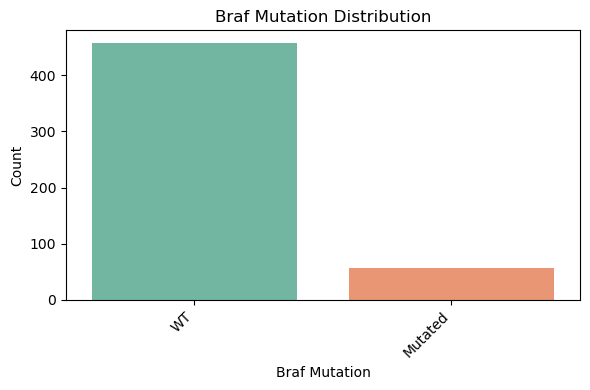

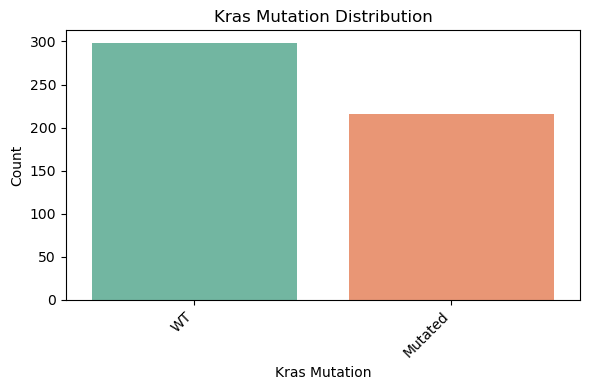

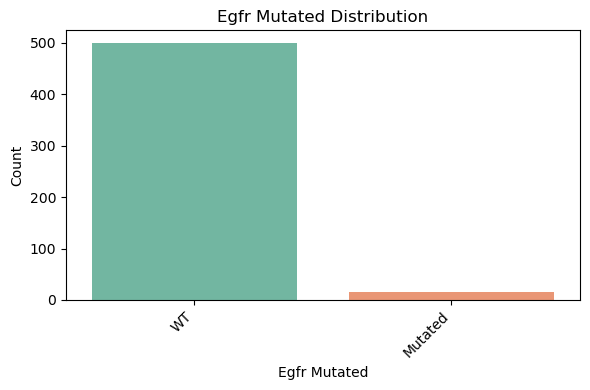

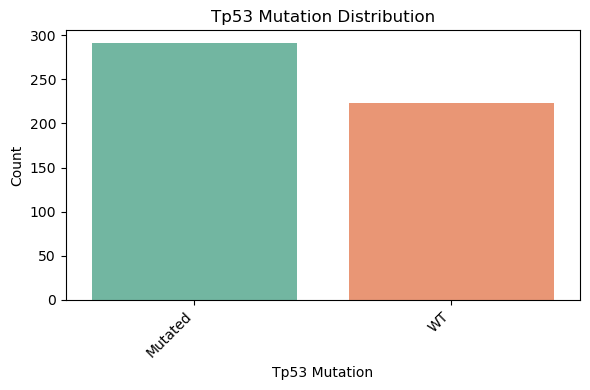

In [40]:
# Mutation columns to explore
mutation_cols = ['braf_mutation', 'kras_mutation', 'egfr_mutated', 'tp53_mutation']
mplt.plot_categorical_distributions(cancer_df, mutation_cols)


In [41]:
# missing values
missing_percent = cancer_df[mutation_cols].isna().mean() * 100
missing_table = missing_percent.reset_index()
missing_table.columns = ['Mutation Column', '% Missing Values']
missing_table

,Mutation Column,% Missing Values
0,braf_mutation,18.152866
1,kras_mutation,18.152866
2,egfr_mutated,18.152866
3,tp53_mutation,18.152866


#### Tumor Characteristic Distributions

The figure shows the distributions of key tumor characteristics among colorectal cancer samples labeled as **Primary cancer**, excluding missing values:

- **Stage**: The majority of samples are in **stage III** and **stage II**, with fewer cases in stages IV and I.
- **Histological Type**: Most samples fall under the category **"Adenomas and adenocarcinomas"**, the rest are different types of **"Neoplasm"** they will be merged together to have only two classes.
- **Histological Subtype**: Dominated by **"Adenocarcinoma"** which is already represented in hitological type so it will be dropped.

Since stage is very important and percentage of missing values is very low, it will be kept and missing values will be imputed later. Histological type does not have any missing values.





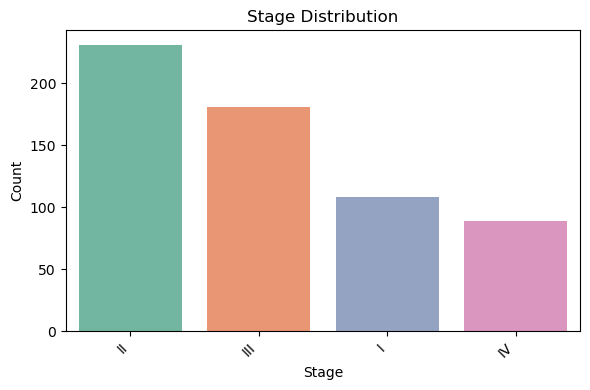

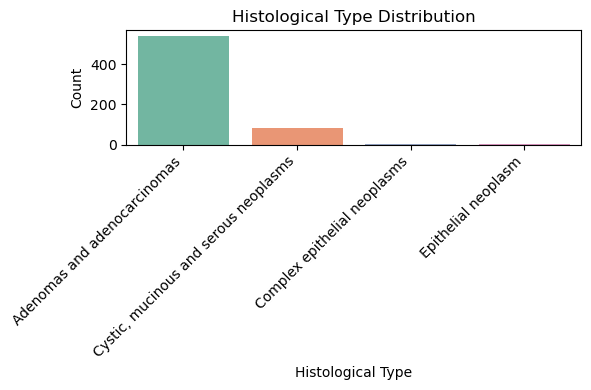

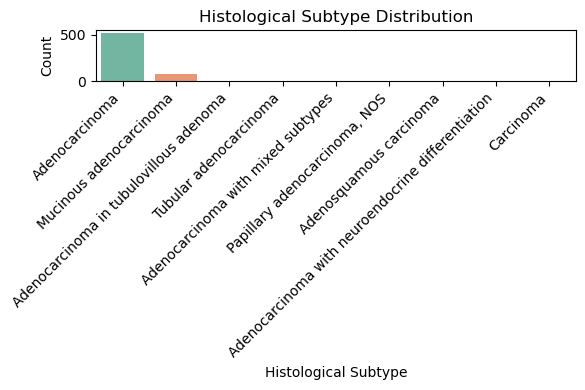

In [42]:
# Tumor characteristic columns to explore
tumor_cols = ['stage','histological_type', 'histological_subtype']
mplt.plot_categorical_distributions(cancer_df, tumor_cols)


In [43]:
# missing values distribution
missing_percent = cancer_df[tumor_cols].isna().mean() * 100
missing_table = missing_percent.reset_index()
missing_table.columns = ['Mutation Column', '% Missing Values']
missing_table

,Mutation Column,% Missing Values
0,stage,3.025478
1,histological_type,0.000000
2,histological_subtype,0.000000


In [44]:
# drop histological subtype
cancer_df = cancer_df.drop(columns=['histological_subtype'])

# merge neoplasms in histological type
neoplasms = metadata_df[metadata_df['histological_type'] != 'Adenomas and adenocarcinomas'].index
cancer_df['histological_type'] = cancer_df['histological_type'].replace(neoplasms, 'neoplasms')


#### Molecular Characteristic Distributions

The figure displays the distributions of key molecular characteristics among colorectal cancer samples labeled as **Primary cancer**, excluding missing values:

- **CMS:** Colorectal cancer is classified into five groups—CMS1 (immune), CMS2 (canonical), CMS3 (metabolic), CMS4 (mesenchymal), and NOLBL (no label). Each subtype has distinct biological features and prognostic implications important for survival analysis. Missing CMS values will be imputed.

- **Molecular Type:** This variable combines multiple types of information and requires cleaning to separate them. It includes:  
  1. Chromosomal stability status  
  2. CIMP (CpG Island Methylator Phenotype) status  
  3. An unknown clustering scheme with clusters 3 and 4, which will be dropped.  
  Note that these columns have over 60% missing values and will be removed eventually dropped. Since the information can be important, another approach is to tag missing values with a specific class but it can still be tricky with many missing values and introduce noise.

- **TMB and TMB Group:** Tumor Mutational Burden (TMB) measures the total number of mutations per megabase (mut/Mb) of tumor DNA. It is categorized into “high” and “low” groups. Since the continuous TMB values are highly skewed and both columns represent the same information, only the categorical TMB group will be retained.


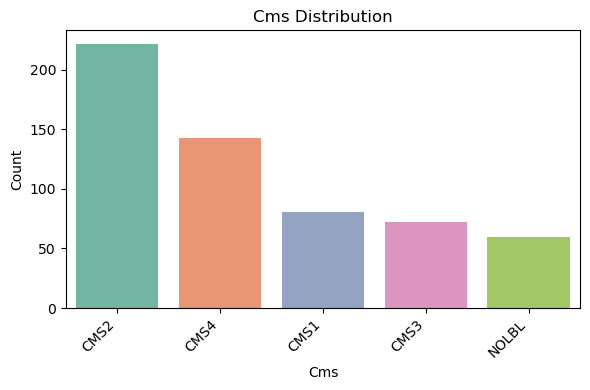

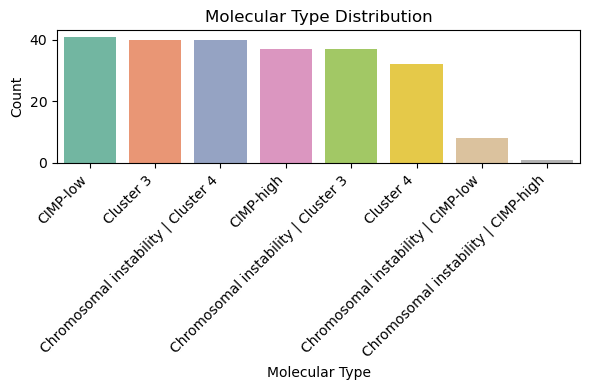

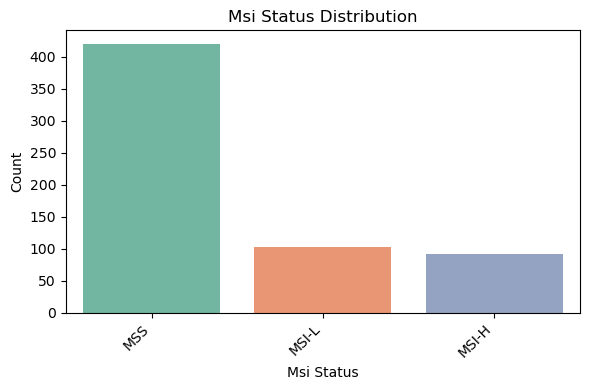

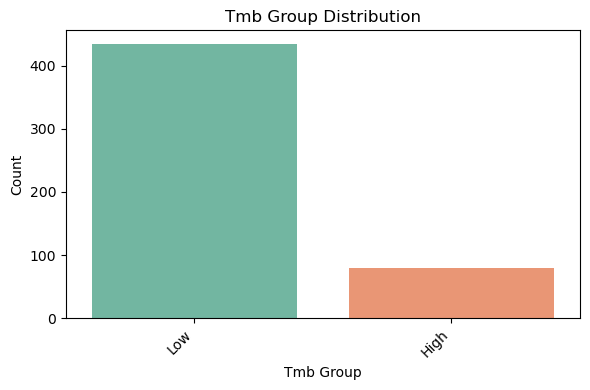

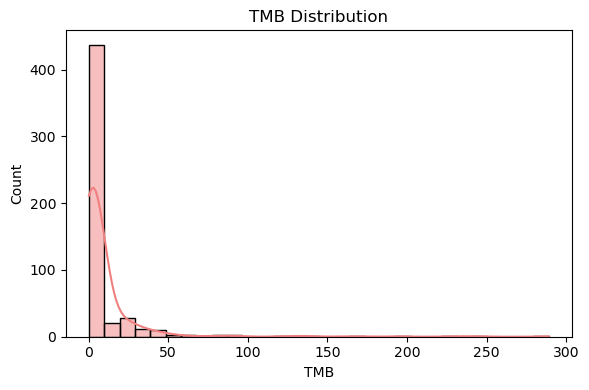

In [45]:
# Molecular classification columns
molecular_categorical = ['cms', 'molecular_type', 'msi_status', 'tmb_group']
molecular_continuous = ['tmb']
mplt.plot_categorical_distributions(cancer_df, molecular_categorical)
mplt.plot_continuous_distributions(cancer_df, molecular_continuous)


In [46]:
# missing values distribution
missing_percent = cancer_df[molecular_categorical+molecular_continuous].isna().mean() * 100
missing_table = missing_percent.reset_index()
missing_table.columns = ['Mutation Column', '% Missing Values']
missing_table

,Mutation Column,% Missing Values
0,cms,7.961783
1,molecular_type,62.420382
2,msi_status,2.388535
3,tmb_group,18.152866
4,tmb,16.878981


In [47]:
# Function to extract  category types from molecular type
def extract_types(val):
    if pd.isna(val):
        return pd.Series([np.nan, np.nan, np.nan])
    
    cluster = np.nan
    cimp = np.nan
    instability = np.nan
    
    if "Cluster" in val:
        cluster = [x for x in val.split(" | ") if "Cluster" in x][0]
    if "CIMP" in val:
        cimp = [x for x in val.split(" | ") if "CIMP" in x][0]
    if "Chromosomal instability" in val:
        instability = 1
    else:
        instability = 0
    
    
    return pd.Series([cluster, cimp, instability])

# Apply function to create new columns
cancer_df[['cluster', 'cimp', 'instability']] =cancer_df['molecular_type'].apply(extract_types)

# drop not needed columns
cancer_df= cancer_df.drop(columns=['molecular_type','cluster','tmb'])

#### Therapy type Information

- **Therapy type:** A lot of classes showing sequence of therapies. It will be turned into first line, second line, and boolean for presence of more than two steps.

- **Prior Treatment:** highly imbalanced, very few samples has yes, will be dropped.


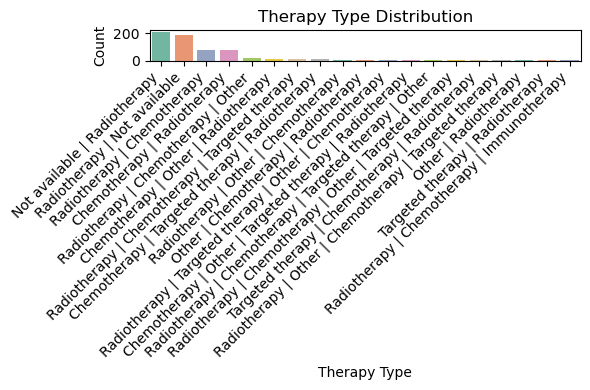

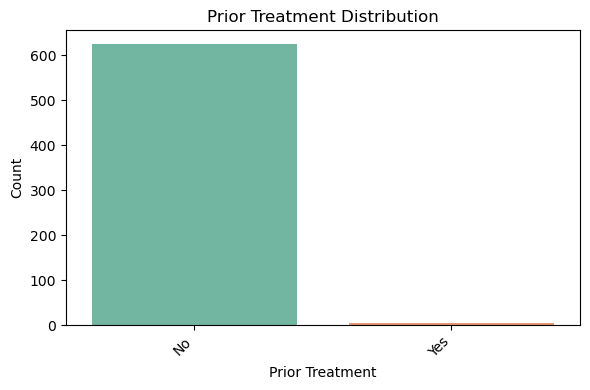

In [48]:
# Define  new column groups
treatment_categorical = ['therapy_type', 'prior_treatment']
mplt.plot_categorical_distributions(cancer_df, treatment_categorical)

In [49]:
# missing values distribution
missing_percent = cancer_df[treatment_categorical].isna().mean() * 100
missing_table = missing_percent.reset_index()
missing_table.columns = ['Mutation Column', '% Missing Values']
missing_table

,Mutation Column,% Missing Values
0,therapy_type,0.0
1,prior_treatment,0.0


In [50]:
# extract therapy information
def extract_first_line(s):
    if '|' not in s:
        return s
    return s.split('|')[0].strip()

def extract_second_line(s):
    if '|' not in s:
        return 'No second line'
    parts = s.split('|')
    if len(parts) > 1:
        return parts[1].strip()

def has_more_than_two_steps(s):
    if '|' not in s:
        return 0
    return int(s.count('|') > 1)

# Apply the new functions
cancer_df['first_line_treatment'] = cancer_df['therapy_type'].apply(extract_first_line)
cancer_df['second_line_treatment'] = cancer_df['therapy_type'].apply(extract_second_line)
cancer_df['has_further_steps'] = cancer_df['therapy_type'].apply(has_more_than_two_steps)


# Drop unneeded columns
cancer_df = cancer_df.drop(columns=['therapy_type', 'prior_treatment'])

#### Finally: Target Distribution

- **OS status:** Indicates survival event, with more censored cases than deaths.

- **OS time:** Observation time measured in days. There is a high concentration of cases near zero, which may complicate survival analysis for those with very short follow-up. Another peak occurs around 500 days, followed by a gradual decline extending up to approximately 5000 days for some samples.


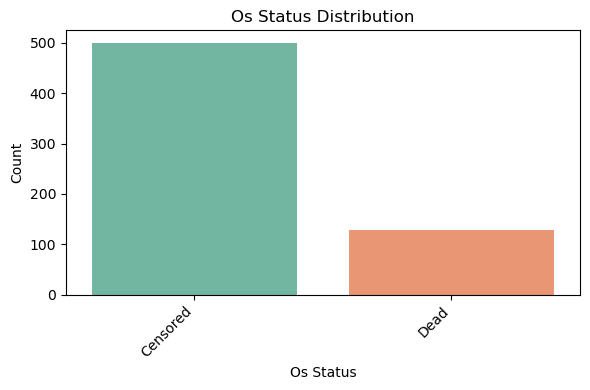

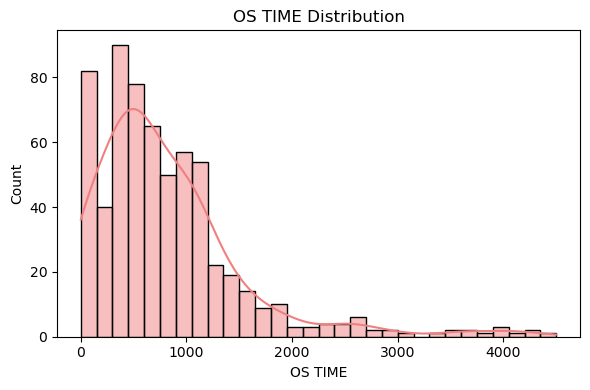

In [51]:
# define variables
survival_categorical = ['os_status']  
survival_continuous = ['os_time']
# plot distrbution
mplt.plot_categorical_distributions(cancer_df, survival_categorical)
mplt. plot_continuous_distributions(cancer_df, survival_continuous)

#### Normalization, HVG, and Dimensionality Reduction

After batch correction using **ComBat-Seq**, the following steps were applied:

1. **Normalization**  
   - Applied TMM normalization, followed by log transformation and Z-score scaling.  
   - Filtered out genes expressed in less than 10% of samples.

2. **Highly Variable Genes (HVG)**  
   - Used Scanpy to identify the top 300 highly variable genes.

3. **Dimensionality Reduction and Visualization**  
   - Performed PCA, followed by t-SNE and UMAP for visualization.  
   - No distinct clusters emerged; data mostly formed a single cluster based on HVGs. A few outliers were detected and removed.


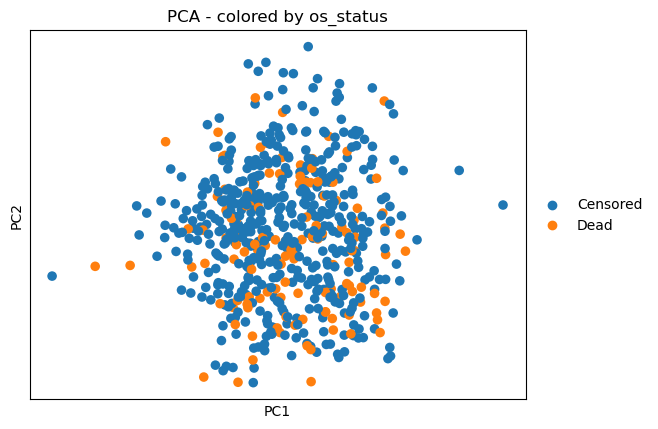

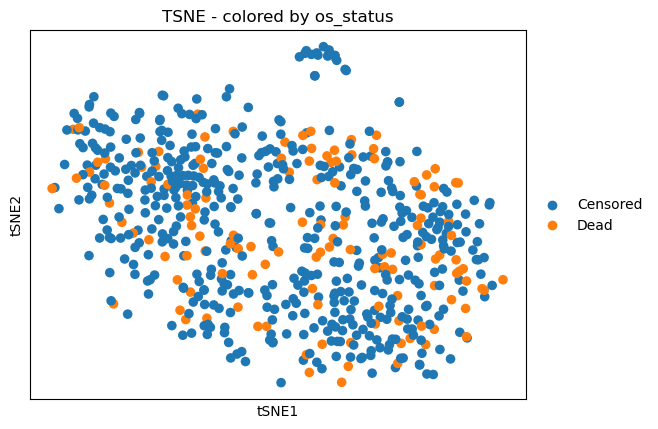

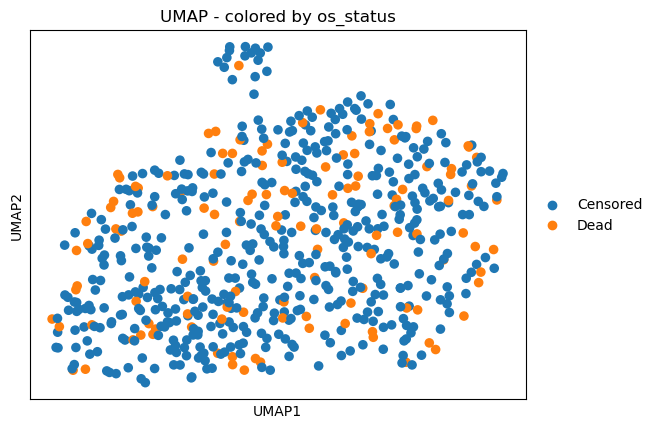

In [52]:
# TMM normalization
expression_df = expression_df.transpose()
expression_tmm = conorm.tmm(expression_df)
# Log scaling
log_tmm = np.log2(expression_tmm + 1)

# Keep genes expressed in at least 10% of the samples
min_samples = log_tmm.shape[1]//5
filtered_expr = log_tmm.loc[(log_tmm > 1).sum(axis=1) > min_samples,:].transpose()
cancer_adata = anndata.AnnData(filtered_expr.loc[filtered_expr.index.intersection(cancer_df.index)])


# Add all columns from metadata_df to adata.obs
for col in cancer_df.columns:
    cancer_adata.obs[col] = cancer_df[col]

# Select Highly Variable Genes 
sc.pp.highly_variable_genes(cancer_adata, flavor='seurat', n_top_genes=200)
cancer_adata = cancer_adata[:, cancer_adata.var['highly_variable']]

# Scale data
sc.pp.scale(cancer_adata)

# PCA
sc.tl.pca(cancer_adata)

# t-SNE
sc.tl.tsne(cancer_adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(cancer_adata, use_rep='X_pca')
sc.tl.umap(cancer_adata)

# t-SNE
sc.tl.tsne(cancer_adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(cancer_adata, use_rep='X_pca')
sc.tl.umap(cancer_adata)

#plotting by biopsy site
mplt.plot_reductions(cancer_adata, 'os_status')

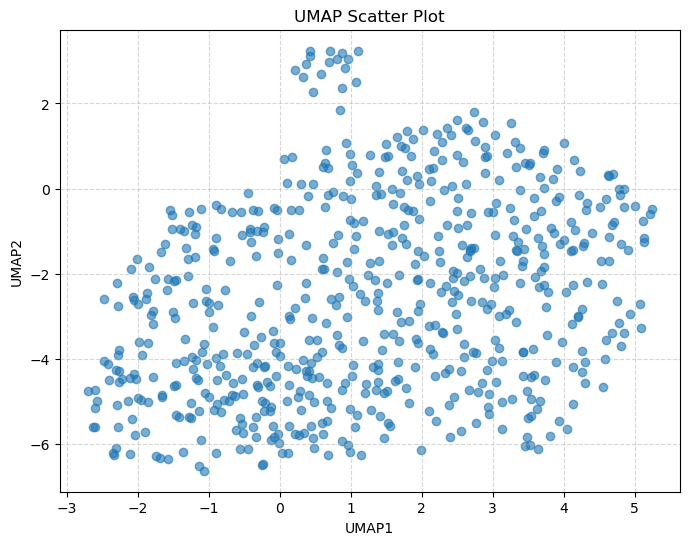

In [53]:
# Extract UMAP coordinates
umap1 = cancer_adata.obsm['X_umap'][:, 0]
umap2 = cancer_adata.obsm['X_umap'][:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(umap1, umap2, alpha=0.6)

# Correct axis labels to find outlier threshold
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP Scatter Plot")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [54]:
# Extract umap scores 
umap2_scores = cancer_adata.obsm['X_umap'][:, 1]

# Define outlier threshold
threshold = 2
mask = umap2_scores < threshold

# Filter AnnData and dataframes to keep only samples within threshold
cancer_adata = cancer_adata[mask, :].copy()
cancer_df = cancer_df.loc[mask]
expression_df = expression_df.transpose().loc[cancer_df.index]
scaled_filtered = scaled_filtered.loc[cancer_df.index]

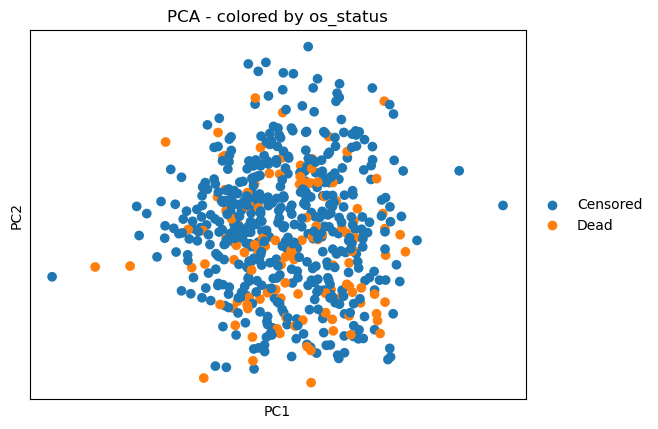

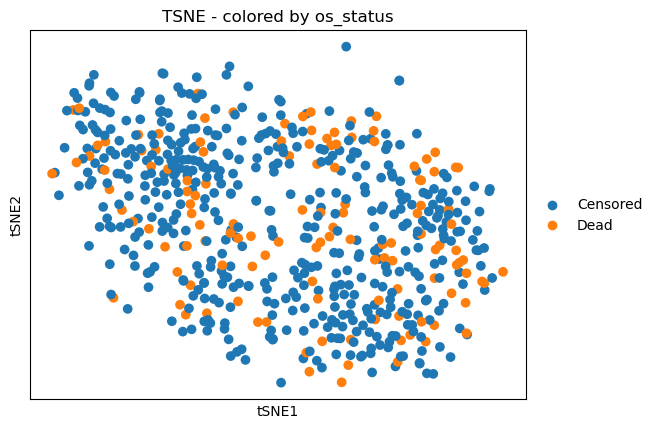

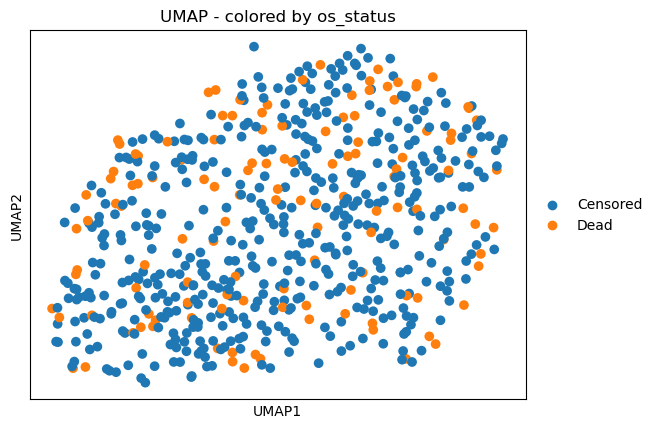

In [55]:
# checcking after outliers removal
mplt.plot_reductions(cancer_adata, 'os_status')

#### From HVGs to Cancer Hallmark Gene Selection

Highly variable genes (HVGs) did not reveal meaningful clustering, even after outlier removal and dimensionality reduction. To better characterize the data, I used Cancer Hallmark gene set (C6) from the MSigDB database. Also, I performed differential expression (DE) analysis followed by gene set enrichment analysis (GSEA) using the this dataset.


In [56]:
# Filter cancer_df for known gender and age
filtered_cancer_df = cancer_df.dropna(subset=['gender', 'age'])

# Get the valid sample IDs/indexes
valid_samples = filtered_cancer_df.index

# Subset expression_df: keep only columns/samples in valid_samples
filtered_expression_df = expression_df.loc[valid_samples]

# Subset scaled_filtered similarly
filtered_scaled_filtered = scaled_filtered.loc[valid_samples]

# Now run the pipeline with filtered datasets
run_pipeline(
    filtered_expression_df,
    filtered_cancer_df,
    filtered_scaled_filtered,
    ['os_status', 'age', 'gender'],
    ('os_status', 'Censored', 'Dead'),
    '../results/cancer_gsea',
    '../data/hallmarks.gmt'
)


🔹 Running DESeq2...


Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.74 seconds.

Fitting dispersions...
... done in 11.03 seconds.

Fitting dispersion trend curve...
... done in 0.87 seconds.

Fitting MAP dispersions...
... done in 17.17 seconds.

Fitting LFCs...
... done in 9.64 seconds.

Calculating cook's distance...
... done in 1.42 seconds.

Replacing 664 outlier genes.

Fitting dispersions...
... done in 0.55 seconds.

Fitting MAP dispersions...
... done in 0.57 seconds.

Fitting LFCs...
... done in 1.31 seconds.

Running Wald tests...
... done in 2.58 seconds.



Log2 fold change & Wald test p-value: os_status Censored vs Dead
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG          1.327222       -0.098031  0.162996 -0.601436  0.547550  0.776458
A1BG-AS1      8.195111        0.023967  0.115475  0.207556  0.835575  0.934913
A1CF        692.375207       -0.053675  0.106285 -0.505010  0.613552  0.820723
A2M       12197.436325       -0.072855  0.102269 -0.712386  0.476226  0.729692
A2M-AS1      14.010878       -0.080714  0.098395 -0.820308  0.412040  0.681119
...                ...             ...       ...       ...       ...       ...
ZYG11A        3.485912       -0.110404  0.189951 -0.581223  0.561090  0.786494
ZYG11B      839.388824        0.075013  0.050380  1.488932  0.136505  0.389588
ZYX        7433.232628       -0.020788  0.067935 -0.305997  0.759607  0.899974
ZZEF1      2091.959086        0.079136  0.063055  1.255025  0.209470  0.486384
ZZZ3       1180.800713        0.064116  0.043450  1.475624  0.1400

#### Hallmark genes Results

- Dimensionality reduction based on Hallmark genes identified two distinct clusters. However, these clusters did not correspond to survival outcomes as initially expected.  
- Using kmeans clustering, these two groups were clearly separated, but they showed little to no correlation with any available clinical or metadata variables.  
- This pattern could indicate a hidden batch effect (such as differences in sequencing platforms) or an unidentified subgroup, but I do not have access to additional information to confirm this.  
- I performed Wilcoxon tests to identify genes that characterize these clusters, though a deeper exploration of these differences is beyond the scope of this study.  
- Since I could not link the clusters to any known variables or batches, I addaed this cluster as a variable and repeated the analysis.Despite these efforts, the survival event remained poorly separated in UMPA/TSNE, so I will not include this clustering from the survival analysis.  
- Nevertheless, it is important to acknowledge that an unmeasured confounding factor might influence the results. Including this cluster in future analyses could provide additional insights.  

Selected genes, based on enriched pathways and curated metadata, will be saved for use in survival analysis in notebook 4.


In [57]:
# Load Hallmark gene set 
hallmark_dict = gp.parser.read_gmt("../data/hallmarks.gmt")
all_hallmark_genes = set()
for genes in hallmark_dict.values():
    all_hallmark_genes.update(genes)
# Flatten GMT to get a list of unique genes
unique_genes = list(all_hallmark_genes)
# Filter expression DataFrame columns by these genes
scaled_df_filtered = scaled_filtered.loc[:, scaled_filtered.columns.isin(unique_genes)]

scaled_df_filtered.shape

(612, 10028)

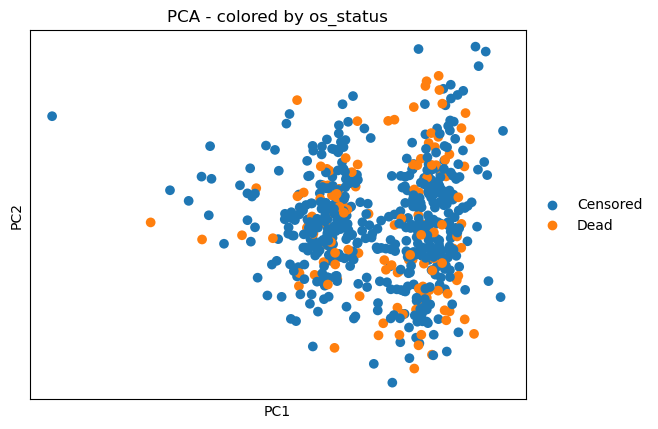

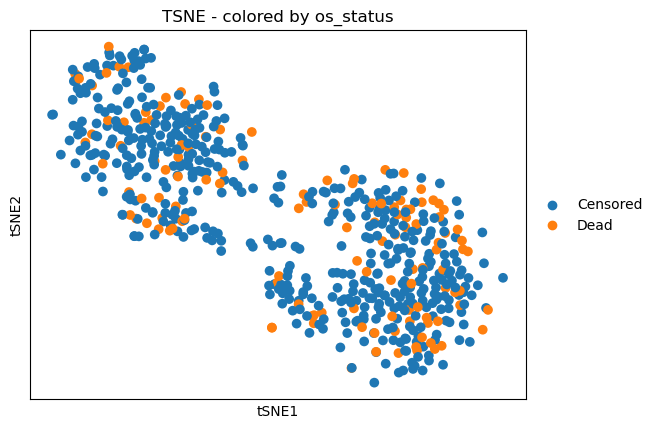

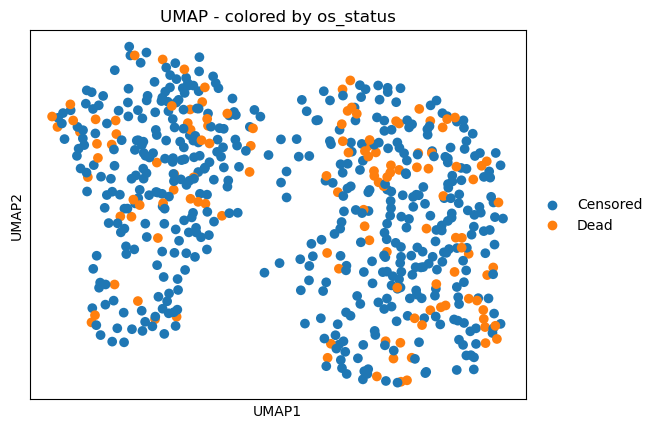

In [58]:
cancer_adata = anndata.AnnData(scaled_df_filtered)
# Add all columns from metadata_df to adata.obs
for col in cancer_df.columns:
    cancer_adata.obs[col] = cancer_df[col]


# PCA
sc.tl.pca(cancer_adata)

# t-SNE
sc.tl.tsne(cancer_adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(cancer_adata, use_rep='X_pca')
sc.tl.umap(cancer_adata)

# t-SNE
sc.tl.tsne(cancer_adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(cancer_adata, use_rep='X_pca')
sc.tl.umap(cancer_adata)

#plotting by biopsy site
mplt.plot_reductions(cancer_adata, 'os_status')

kmeans
0    338
1    274
Name: count, dtype: int64


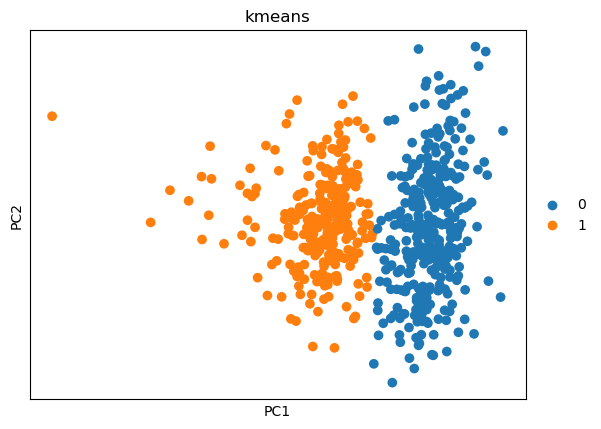

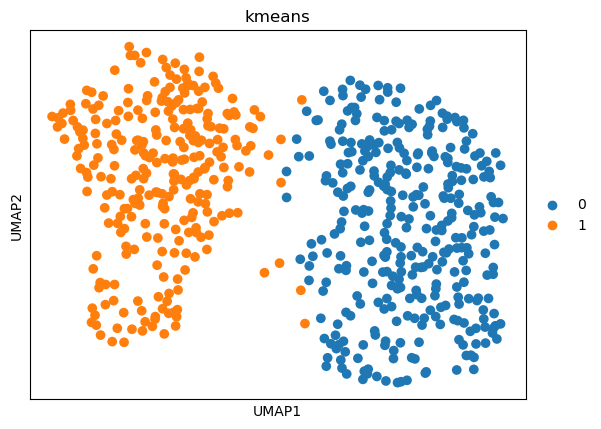

In [59]:
# Run k-means on PCA coordinates
# Here n_clusters should be set by you (e.g., based on elbow method or silhouette score)
kmeans = KMeans(n_clusters=2, random_state=0)
cancer_adata.obs['kmeans'] = kmeans.fit_predict(cancer_adata.obsm['X_pca']).astype(str)

# Check cluster sizes
print(cancer_adata.obs['kmeans'].value_counts())

# Plot PCA with k-means clusters
sc.pl.pca(cancer_adata, color=['kmeans'])

# Plot UMAP with k-means clusters
sc.pl.umap(cancer_adata, color=['kmeans'])


In [60]:
# similarity between kmeans clusters and different metadata
if 'kmeans' in cancer_adata.obs.columns:
    ref = cancer_adata.obs['kmeans'].astype(str).values
    scores = {}
    for col in cancer_adata.obs.columns:
        vals = cancer_adata.obs[col].astype(str).values
        try:
            scores[col] = adjusted_rand_score(ref, vals)
        except Exception:
            scores[col] = np.nan
    # rank columns by similarity to 'kmeans'
    # print(sorted(scores.items(), key=lambda x: - (x[1] if x[1] is not None else -1))[:10])
print(scores)

{'age': -0.00025619514670276574, 'biopsy_subsite': 0.0016166530435273575, 'braf_mutation': -0.004097546456916102, 'biopsy_site': -0.001424513666446422, 'cms': 0.005665623525801956, 'distal_vs_proximal': -0.0005864985949551314, 'egfr_mutated': -0.0019442628615446663, 'histological_type': 0.00571666447658142, 'kras_mutation': -0.002984784322107485, 'msi_status': -0.003157169726015347, 'os_status': -0.004733623564050927, 'os_time': 0.0023406314467898605, 'primary_site': -0.001424513666446422, 'gender': 0.0007231785390140323, 'stage': 0.00015374454198692687, 'tmb_group': -0.0017274982804336447, 'tp53_mutation': 0.0021679572831029854, 'cimp': 0.10748156597478453, 'instability': 0.5463060707614377, 'first_line_treatment': -0.0032764526585457453, 'second_line_treatment': 0.0035758147720295736, 'has_further_steps': -0.00044226098169765257, 'kmeans': 1.0}


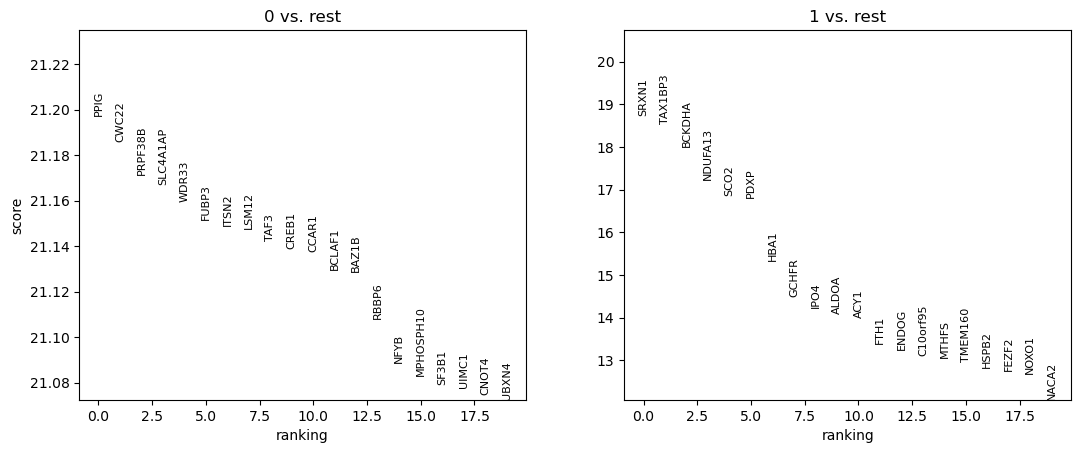

In [61]:
# high rank genes in each cluster
sc.tl.rank_genes_groups(cancer_adata, 'kmeans', method='wilcoxon')
sc.pl.rank_genes_groups(cancer_adata, n_genes=20, sharey=False)

In [62]:
# dropping these two columns since they have high percent missing values and no influence on the cluster
cancer_df= cancer_df.drop(columns=['cimp', 'instability'])
# Filter expression DataFrame columns by these genes
filtered_expr =  filtered_expr.loc[:, filtered_expr.columns.isin(unique_genes)]


In [63]:
# save data
cancer_df.to_csv('../data/cancer_metadata.csv')
filtered_expr.to_csv('../data/cancer_tmm_log.csv')


## Test if cluster inclusion improves seperation:

🔹 Running DESeq2...


Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.69 seconds.

Fitting dispersions...
... done in 21.09 seconds.

Fitting dispersion trend curve...
... done in 1.06 seconds.

Fitting MAP dispersions...
... done in 21.29 seconds.

Fitting LFCs...
... done in 18.69 seconds.

Calculating cook's distance...
... done in 2.26 seconds.

Replacing 651 outlier genes.

Fitting dispersions...
... done in 0.95 seconds.

Fitting MAP dispersions...
... done in 0.62 seconds.

Fitting LFCs...
... done in 1.60 seconds.

Running Wald tests...
... done in 2.87 seconds.



Log2 fold change & Wald test p-value: os_status Censored vs Dead
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG          1.327222       -0.101990  0.163490 -0.623832  0.532738  0.791913
A1BG-AS1      8.195111       -0.044422  0.112383 -0.395273  0.692642  0.879437
A1CF        692.375207       -0.019023  0.105612 -0.180123  0.857056  0.955602
A2M       12197.436325       -0.011824  0.099653 -0.118652  0.905551  0.971765
A2M-AS1      14.010878       -0.103499  0.098462 -1.051151  0.293189  0.613355
...                ...             ...       ...       ...       ...       ...
ZYG11A        3.485912       -0.155151  0.188458 -0.823269  0.410355  0.710344
ZYG11B      839.388824        0.105553  0.048108  2.194084  0.028229  0.177885
ZYX        7433.232628       -0.084532  0.065103 -1.298431  0.194139  0.503659
ZZEF1      2091.959086        0.092896  0.062643  1.482954  0.138087  0.423602
ZZZ3       1180.800713        0.079617  0.042723  1.863554  0.0623

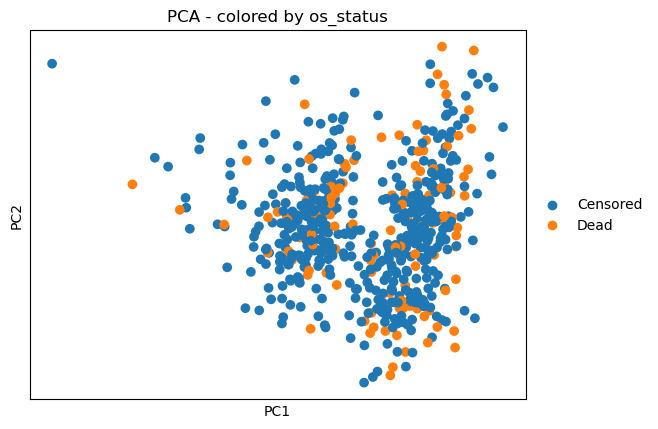

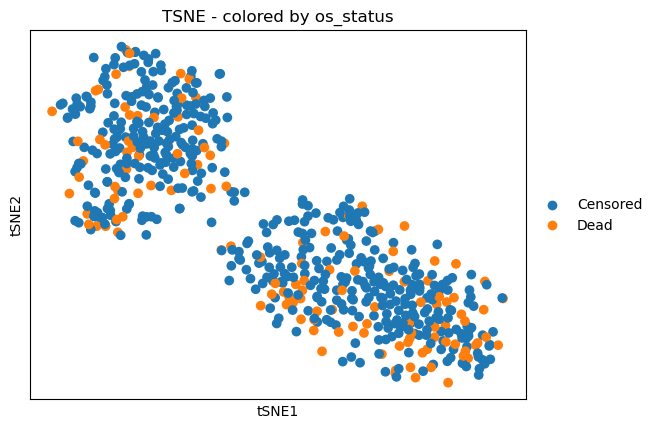

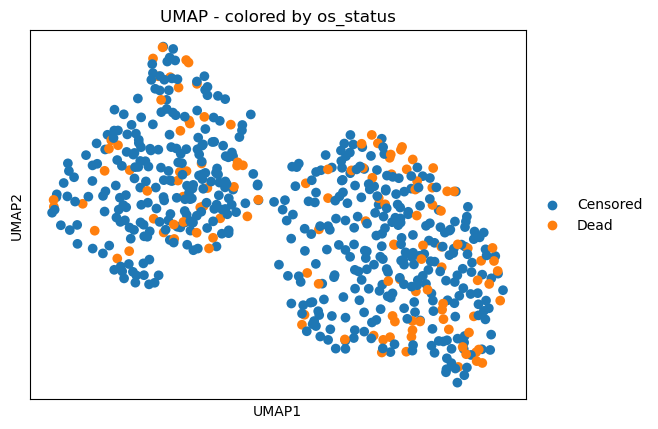

In [64]:
# Filter cancer_df for known gender and age
filtered_cancer_df['cluster'] = cancer_adata.obs['kmeans']

# Now run the pipeline with filtered datasets
run_pipeline(
    filtered_expression_df,
    filtered_cancer_df,
    filtered_scaled_filtered,
    ['os_status', 'age', 'gender','cluster'],
    ('os_status', 'Censored', 'Dead'),
    '../results/cancer_gsea_cluster',
    '../data/hallmarks.gmt'
)
# extracting the genes from cancer enriched pathways
pre_res= pd.read_csv('../results/cancer_gsea_cluster/gsea_results/gsea_summary.csv')
significant_sets = pre_res[pre_res['FDR q-val'] < 0.25]
# Flatten all genes split by ';' into a list
all_genes = [g for gene_str in significant_sets['Lead_genes'] for g in gene_str.split(';')]

# Get unique genes
unique_genes = list(set(all_genes))

# Filter expression DataFrame columns by these genes
scaled_df_filtered = scaled_filtered.loc[:, scaled_filtered.columns.isin(unique_genes)]

scaled_df_filtered.shape
cancer_adata = anndata.AnnData(scaled_df_filtered)
# Add all columns from metadata_df to adata.obs
for col in cancer_df.columns:
    cancer_adata.obs[col] = cancer_df[col]


# PCA
sc.tl.pca(cancer_adata)

# t-SNE
sc.tl.tsne(cancer_adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(cancer_adata, use_rep='X_pca')
sc.tl.umap(cancer_adata)

# t-SNE
sc.tl.tsne(cancer_adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(cancer_adata, use_rep='X_pca')
sc.tl.umap(cancer_adata)

#plotting by biopsy site
mplt.plot_reductions(cancer_adata, 'os_status',save_dir= '../results/dimenionality_reduction_cluster')